# Unsupervised Learning Project: Customer Segmentation Analysis

## 1. Problem Description and Data Collection

### Problem Description
This project focuses on customer segmentation using unsupervised learning techniques. The goal is to identify distinct groups of customers based on their purchasing behavior and demographic characteristics. This segmentation can help businesses develop targeted marketing strategies and personalized customer experiences.

### Data Source
The dataset used is the "Mall Customer Segmentation Data" from Kaggle, which contains basic information about mall customers. This is a publicly available dataset commonly used for clustering exercises.

**Data Provenance:**
- Source: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python
- Collection Method: The data was likely collected through mall membership cards and customer surveys
- Contains: 200 records with 5 customer attributes

## GitHub
GitHub URL: https://github.com/xllcheryl/Unsupervised-Algorithms-in-Machine-Learning-Final-Project

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 2. Data Loading and Initial Inspection

In [2]:
# Load the dataset
df = pd.read_csv('Mall_Customers.csv')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [5]:
# Statistical summary
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


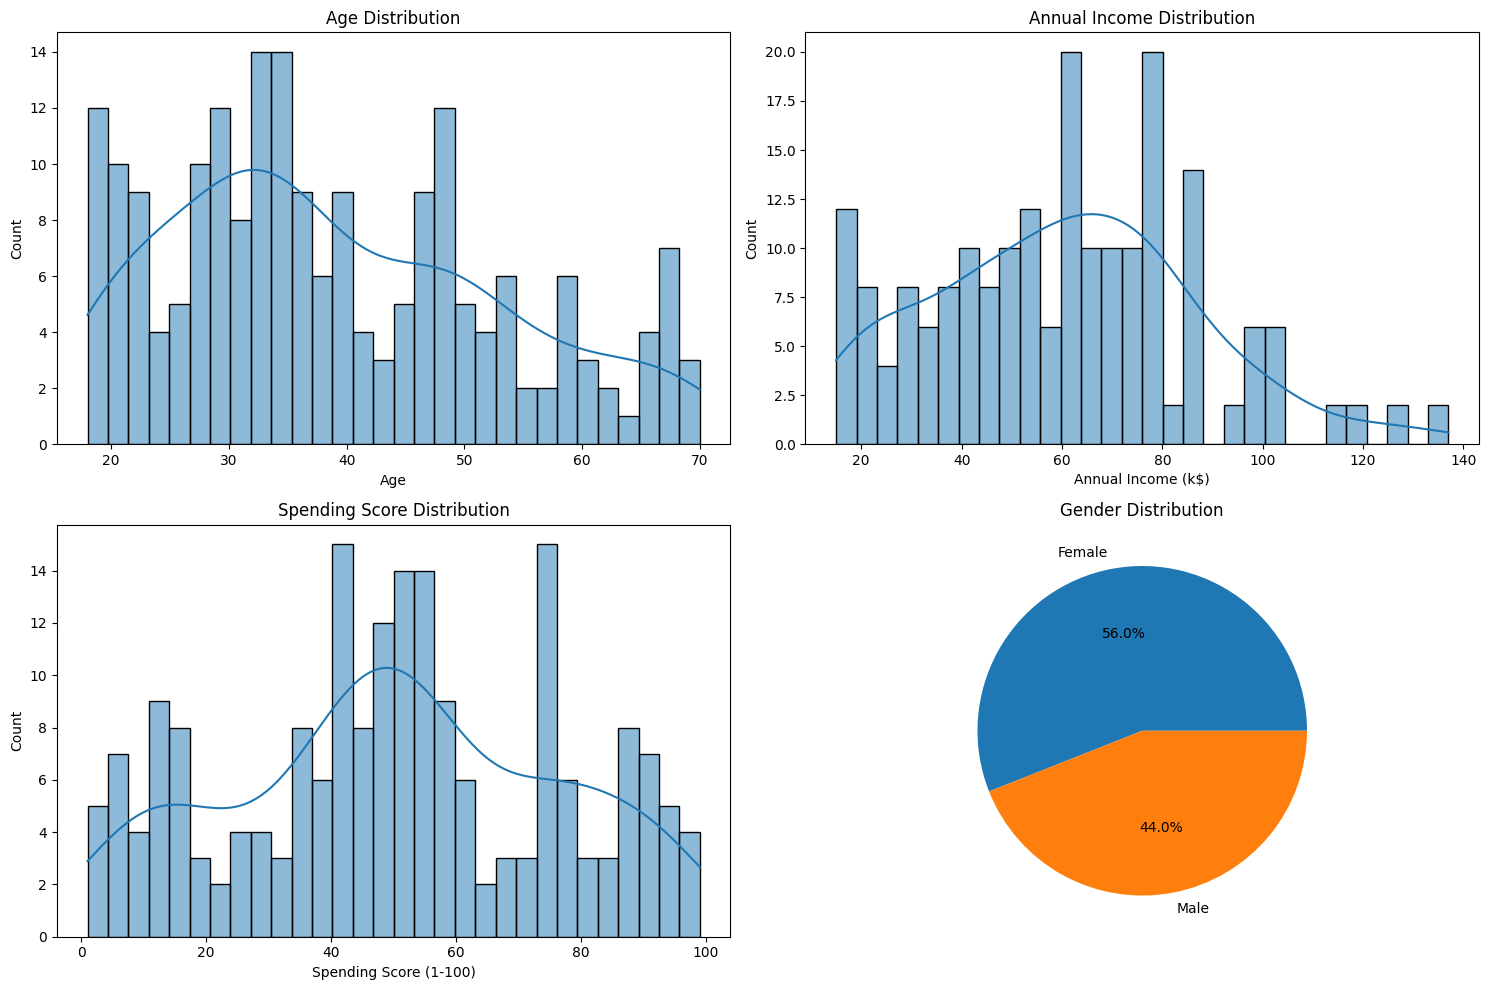

In [6]:
# Distribution of numerical features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age distribution
sns.histplot(df['Age'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution')

# Annual Income distribution
sns.histplot(df['Annual Income (k$)'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Annual Income Distribution')

# Spending Score distribution
sns.histplot(df['Spending Score (1-100)'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Spending Score Distribution')

# Gender distribution
gender_counts = df['Gender'].value_counts()
axes[1, 1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
axes[1, 1].set_title('Gender Distribution')

plt.tight_layout()
plt.show()


### 3.2 Bivariate Analysis

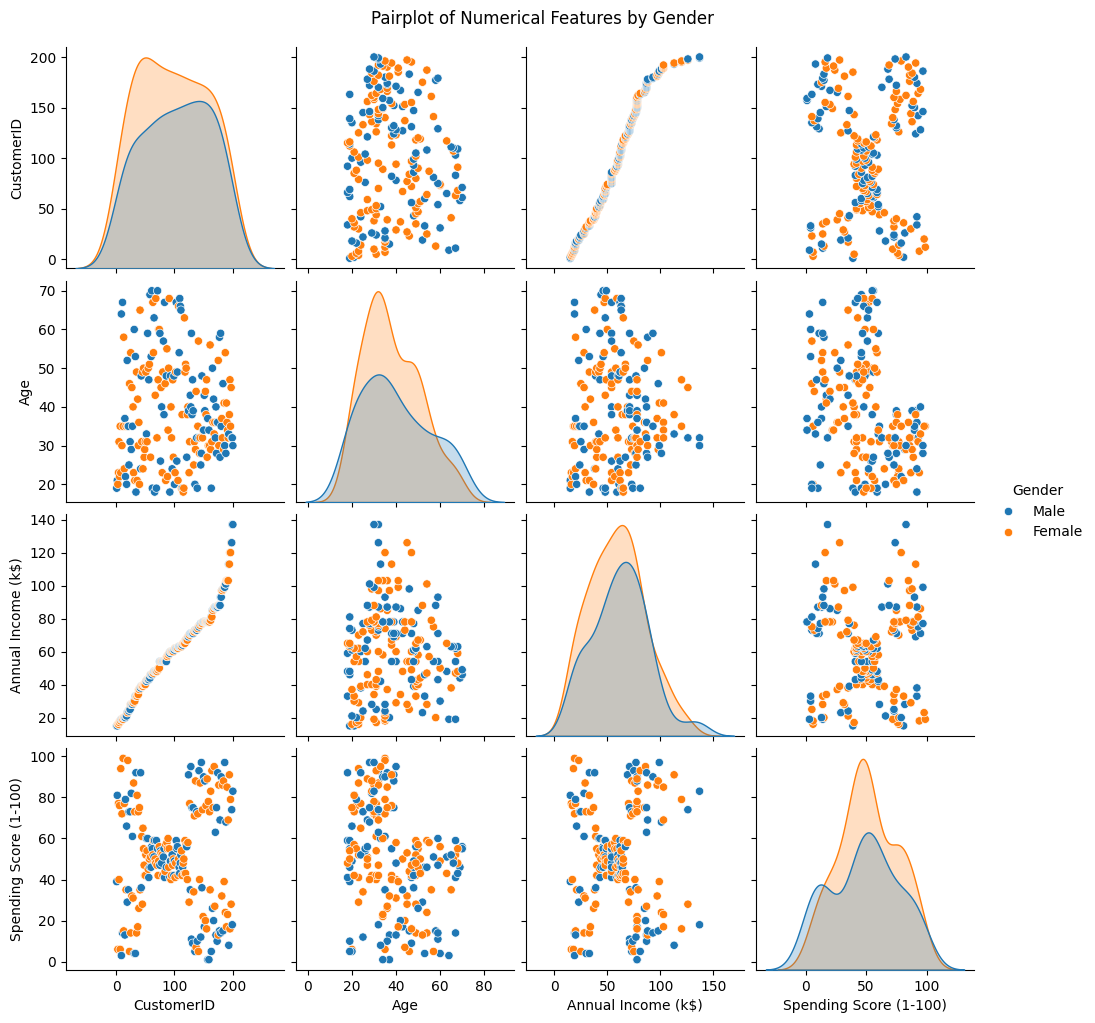

In [7]:
# Pairplot to visualize relationships between numerical features
sns.pairplot(df, hue='Gender', diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features by Gender', y=1.02)
plt.show()

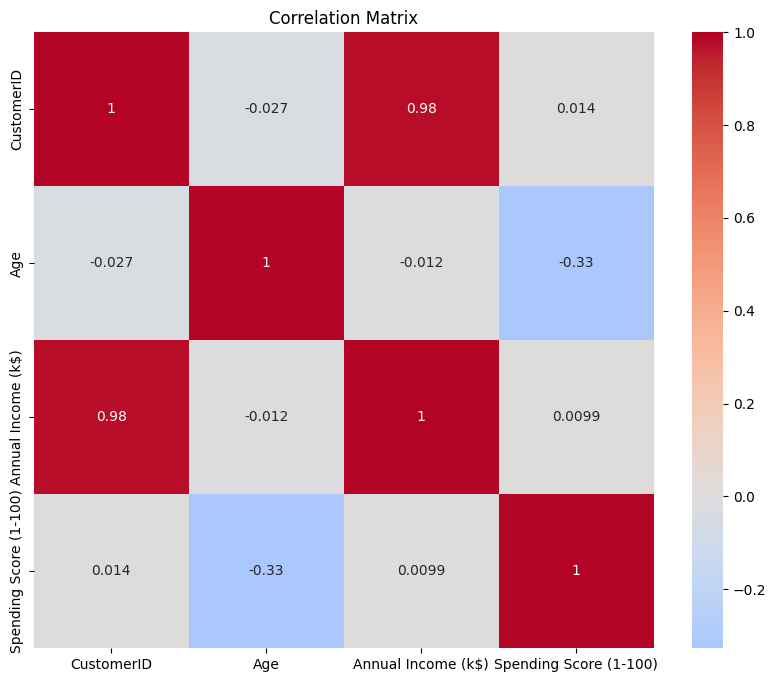

In [8]:
# Correlation matrix
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

### 3.3 Data Preprocessing

In [9]:
# Encode categorical variable (Gender)
df_processed = df.copy()
df_processed['Gender'] = df_processed['Gender'].map({'Female': 0, 'Male': 1})

# Select features for clustering
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender']
X = df_processed[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled data shape:", X_scaled.shape)

Scaled data shape: (200, 4)


## 4. Dimensionality Reduction with PCA

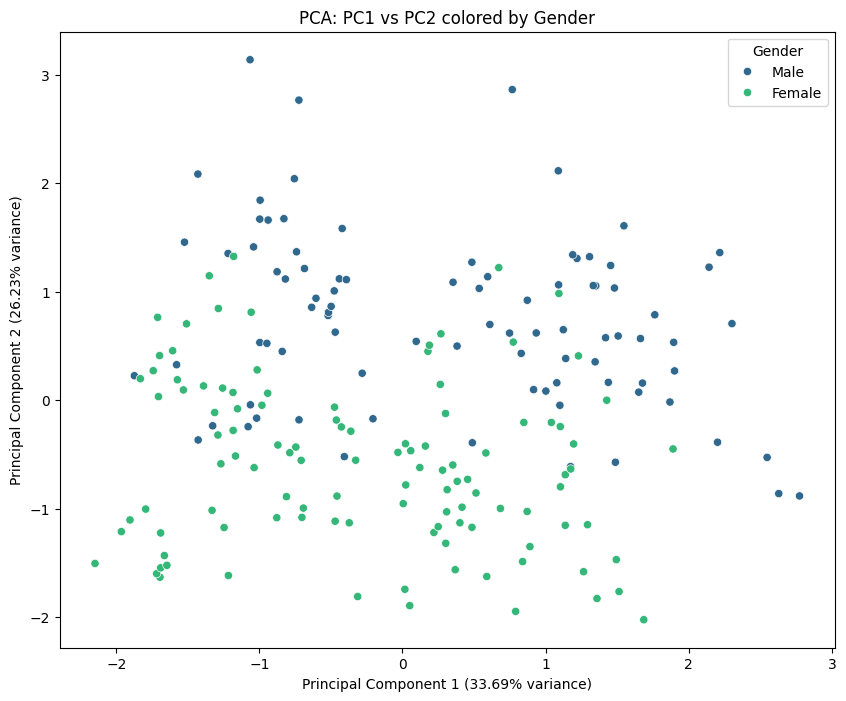

Explained variance ratio: [0.33690046 0.26230645]
Total explained variance: 59.92%


In [10]:
# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df = pd.concat([pca_df, df['Gender']], axis=1)

# Visualize PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Gender', data=pca_df, palette='viridis')
plt.title('PCA: PC1 vs PC2 colored by Gender')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend(title='Gender')
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

## 5. Determining Optimal Number of Clusters

### 5.1 Elbow Method

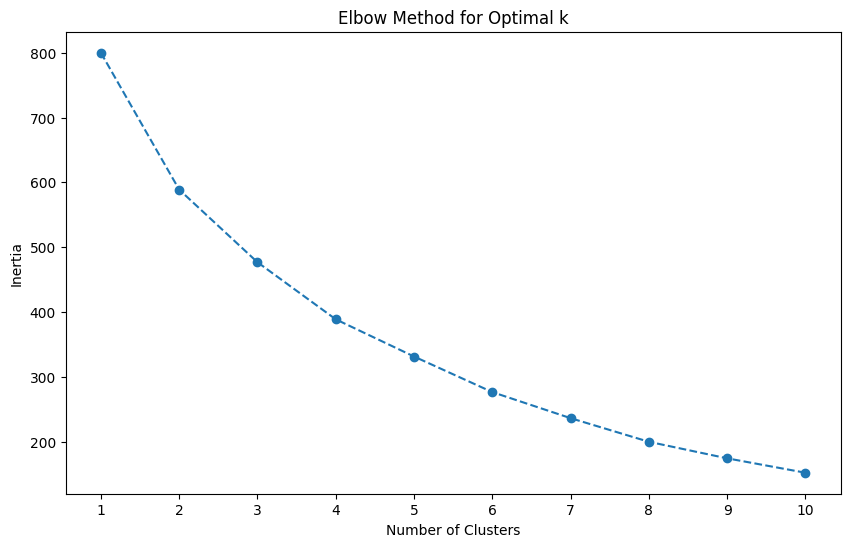

In [11]:
# Elbow method to find optimal k
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.show()

### 5.2 Silhouette Analysis

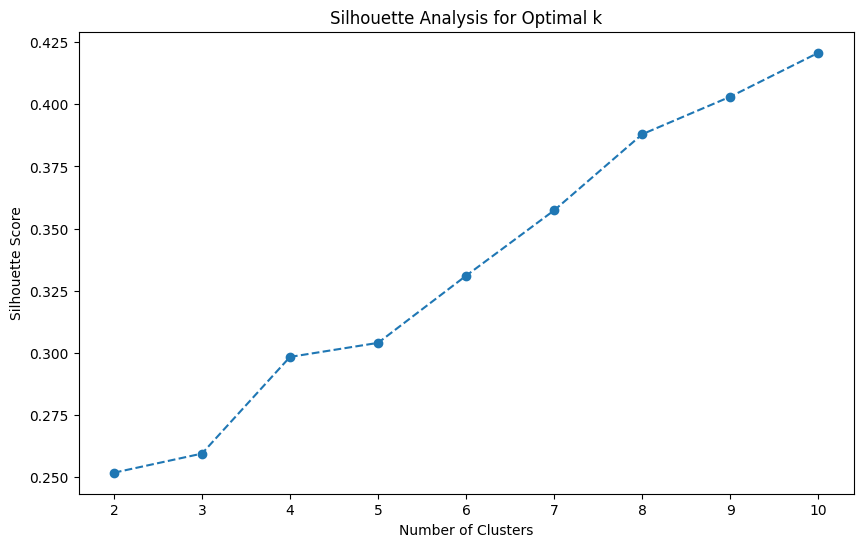

In [12]:
# Silhouette analysis
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.xticks(k_range)
plt.show()

## 6. Model Building and Training

### 6.1 K-Means Clustering

In [13]:
# Apply K-Means with optimal k
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['KMeans_Cluster'] = kmeans_labels

# Evaluate K-Means
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_ch_score = calinski_harabasz_score(X_scaled, kmeans_labels)
kmeans_db_score = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")
print(f"K-Means Calinski-Harabasz Score: {kmeans_ch_score:.3f}")
print(f"K-Means Davies-Bouldin Score: {kmeans_db_score:.3f}")

K-Means Silhouette Score: 0.304
K-Means Calinski-Harabasz Score: 68.965
K-Means Davies-Bouldin Score: 1.167


### 6.2 Gaussian Mixture Model (GMM)

In [14]:
# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['GMM_Cluster'] = gmm_labels

# Evaluate GMM
gmm_silhouette = silhouette_score(X_scaled, gmm_labels)
gmm_ch_score = calinski_harabasz_score(X_scaled, gmm_labels)
gmm_db_score = davies_bouldin_score(X_scaled, gmm_labels)

print(f"GMM Silhouette Score: {gmm_silhouette:.3f}")
print(f"GMM Calinski-Harabasz Score: {gmm_ch_score:.3f}")
print(f"GMM Davies-Bouldin Score: {gmm_db_score:.3f}")

GMM Silhouette Score: 0.222
GMM Calinski-Harabasz Score: 45.817
GMM Davies-Bouldin Score: 1.211


### 6.3 Hierarchical Clustering

In [15]:
# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k)
agg_labels = agg_clustering.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['Hierarchical_Cluster'] = agg_labels

# Evaluate Hierarchical Clustering
agg_silhouette = silhouette_score(X_scaled, agg_labels)
agg_ch_score = calinski_harabasz_score(X_scaled, agg_labels)
agg_db_score = davies_bouldin_score(X_scaled, agg_labels)

print(f"Agglomerative Clustering Silhouette Score: {agg_silhouette:.3f}")
print(f"Agglomerative Clustering Calinski-Harabasz Score: {agg_ch_score:.3f}")
print(f"Agglomerative Clustering Davies-Bouldin Score: {agg_db_score:.3f}")

Agglomerative Clustering Silhouette Score: 0.287
Agglomerative Clustering Calinski-Harabasz Score: 64.469
Agglomerative Clustering Davies-Bouldin Score: 1.220


## 7. Results Visualization and Analysis

### 7.1 Cluster Visualization

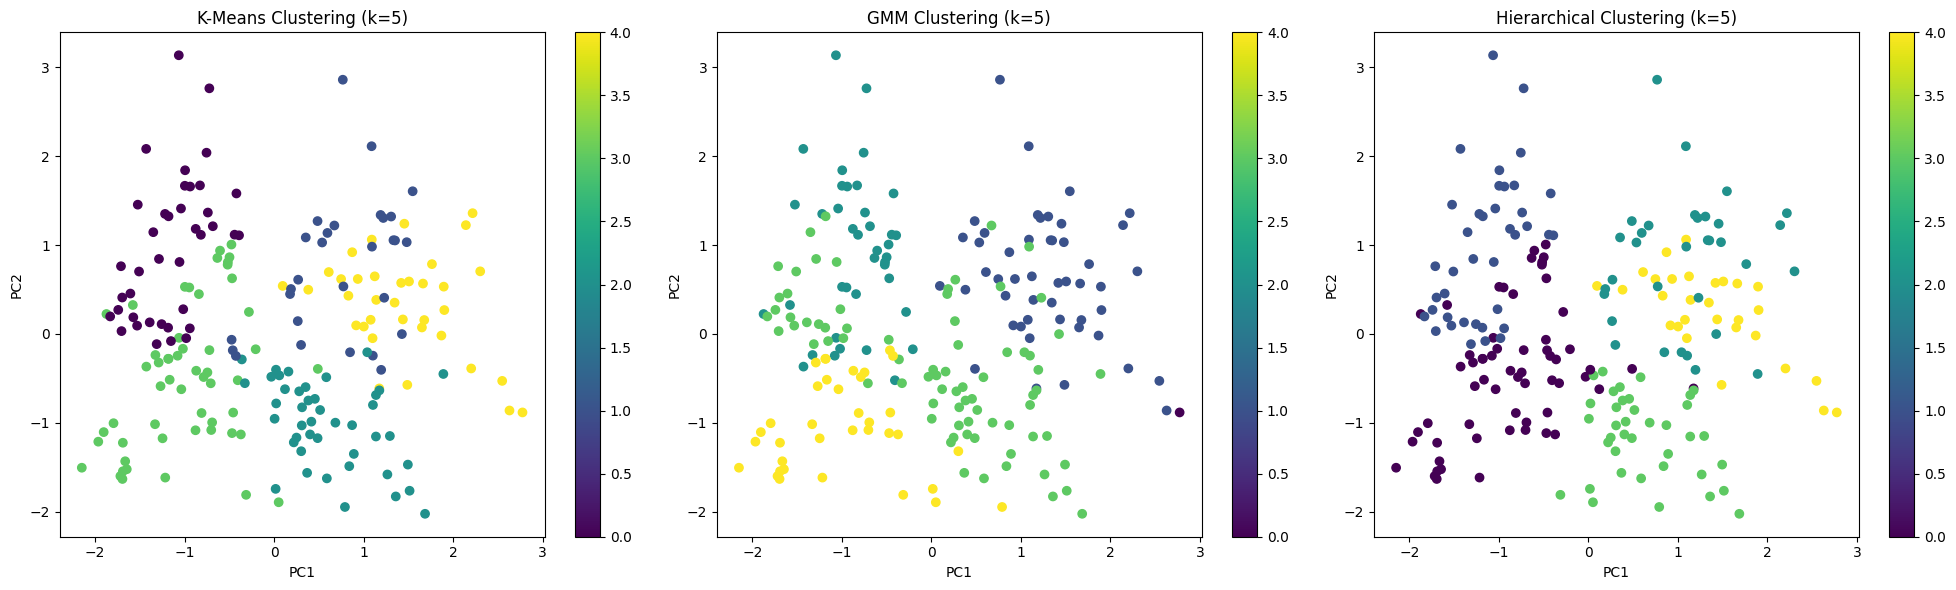

In [16]:
# Visualize clusters using the first two principal components
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# K-Means clusters
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
axes[0].set_title(f'K-Means Clustering (k={optimal_k})')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
plt.colorbar(scatter1, ax=axes[0])

# GMM clusters
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis')
axes[1].set_title(f'GMM Clustering (k={optimal_k})')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
plt.colorbar(scatter2, ax=axes[1])

# Hierarchical clusters
scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='viridis')
axes[2].set_title(f'Hierarchical Clustering (k={optimal_k})')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
plt.colorbar(scatter3, ax=axes[2])

plt.tight_layout()
plt.show()

### 7.2 Cluster Profiling

In [17]:
# Analyze cluster characteristics (using K-Means results)
cluster_profile = df.groupby('KMeans_Cluster').agg({
    'Age': 'mean',
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean',
    'Gender': lambda x: (x == 'Female').sum() / len(x) * 100  # Percentage of females
}).round(2)

cluster_profile.columns = ['Avg Age', 'Avg Annual Income (k$)', 'Avg Spending Score', 'Female %']
print("Cluster Profile (K-Means):")
cluster_profile

Cluster Profile (K-Means):


,Avg Age,Avg Annual Income (k$),Avg Spending Score,Female %
KMeans_Cluster,,,,
0,32.69,86.54,82.13,53.85
1,36.48,89.52,18.00,55.17
2,49.81,49.23,40.07,100.00
3,24.91,39.72,61.20,59.26
4,55.71,53.69,36.77,0.00


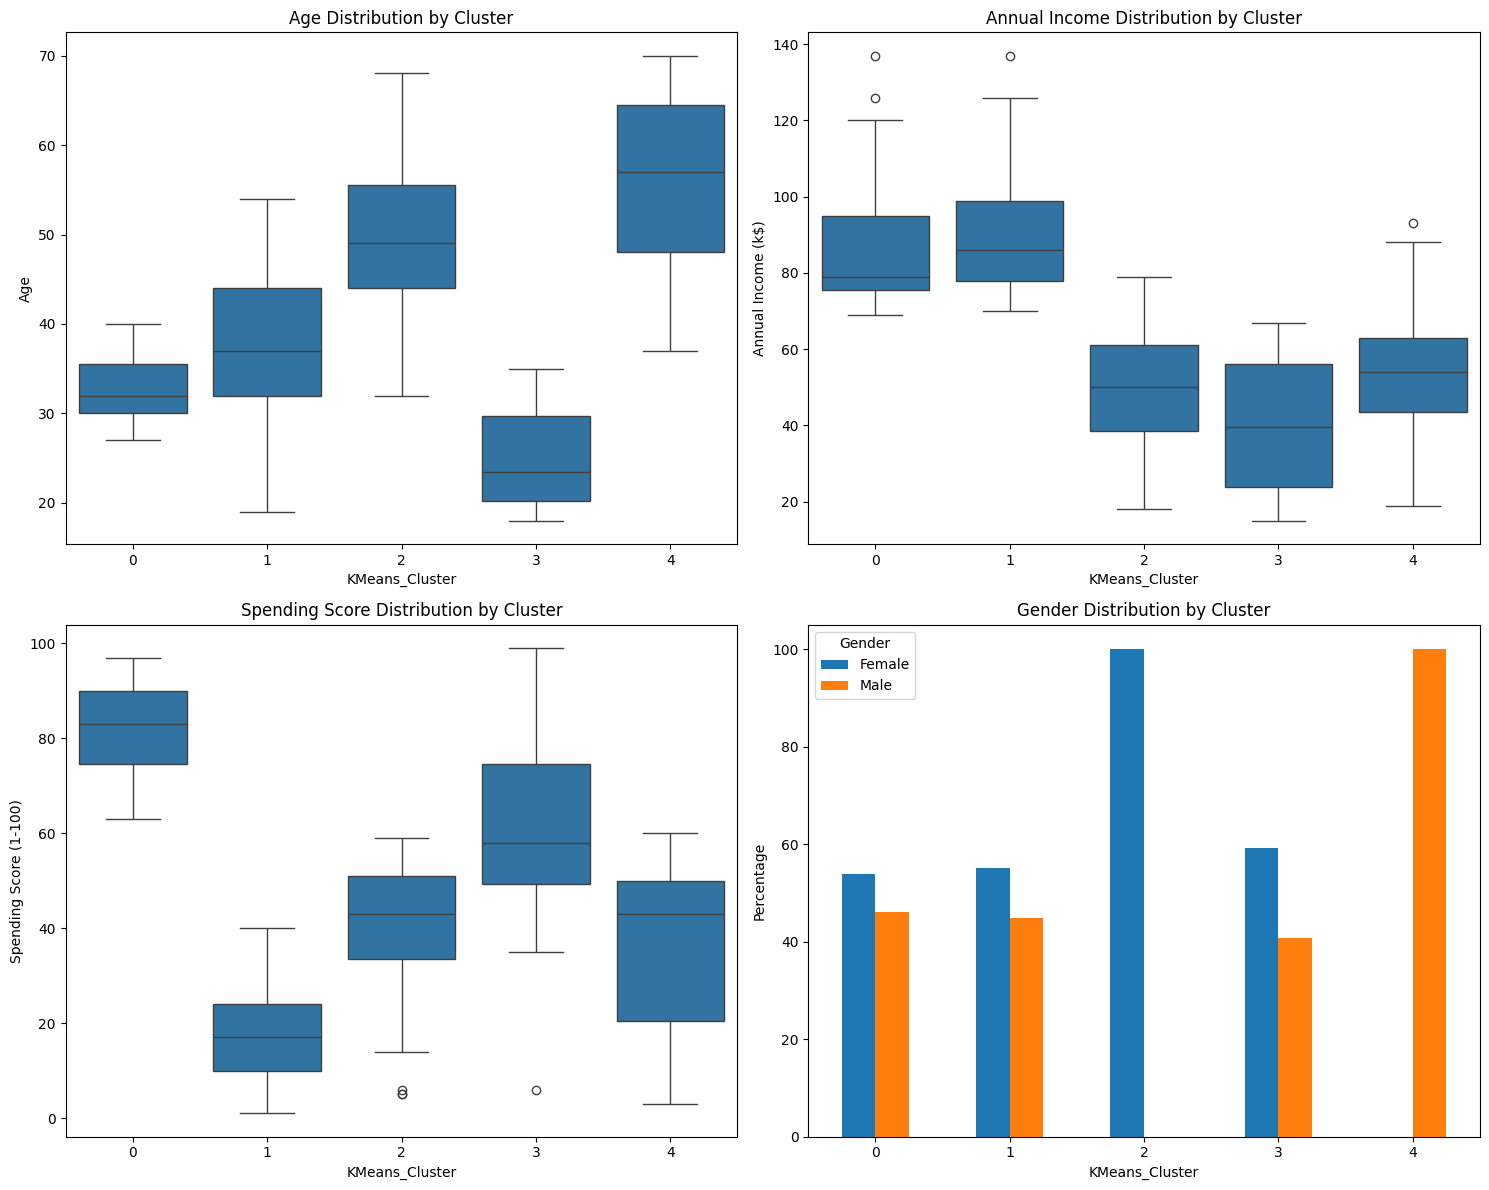

In [18]:
# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Age distribution by cluster
sns.boxplot(x='KMeans_Cluster', y='Age', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution by Cluster')

# Income distribution by cluster
sns.boxplot(x='KMeans_Cluster', y='Annual Income (k$)', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Annual Income Distribution by Cluster')

# Spending score distribution by cluster
sns.boxplot(x='KMeans_Cluster', y='Spending Score (1-100)', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Spending Score Distribution by Cluster')

# Gender distribution by cluster
gender_cluster = pd.crosstab(df['KMeans_Cluster'], df['Gender'], normalize='index') * 100
gender_cluster.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Gender Distribution by Cluster')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### 7.3 Comparison of Algorithms

In [19]:
# Compare algorithm performance
algorithms = ['K-Means', 'GMM', 'Hierarchical']
silhouette_scores = [kmeans_silhouette, gmm_silhouette, agg_silhouette]
ch_scores = [kmeans_ch_score, gmm_ch_score, agg_ch_score]
db_scores = [kmeans_db_score, gmm_db_score, agg_db_score]

comparison_df = pd.DataFrame({
    'Algorithm': algorithms,
    'Silhouette Score': silhouette_scores,
    'Calinski-Harabasz Score': ch_scores,
    'Davies-Bouldin Score': db_scores
}).round(3)

print("Algorithm Comparison:")
comparison_df

Algorithm Comparison:


,Algorithm,Silhouette Score,Calinski-Harabasz Score,Davies-Bouldin Score
0,K-Means,0.304,68.965,1.167
1,GMM,0.222,45.817,1.211
2,Hierarchical,0.287,64.469,1.220


## 8. Discussion and Conclusion

### 8.1 Discussion

Based on the analysis, we can interpret the customer segments as follows:

1. **Cluster 0 (High Income, High Spending)**: Younger to middle-aged customers (avg 32.7 years) with high income (avg $86.5k) and high spending score (82.1). This represents the premium segment that should be targeted with luxury products and exclusive offers.

2. **Cluster 1 (High Income, Low Spending)**: Middle-aged customers (avg 36.5 years) with high income (avg $89.5k) but low spending score (18.0). This group may be focused on saving or investing rather than discretionary spending. They might respond better to value-based messaging.

3. **Cluster 2 (Moderate Income, Moderate Spending)**: Older female customers (avg 49.8 years, 100% female) with moderate income ($49.2k) and spending (40.1). This segment may represent practical shoppers who make considered purchases.

4. **Cluster 3 (Low Income, High Spending)**: Young customers (avg 24.9 years) with lower income ($39.7k) but high spending score (61.2). This group may be more fashion-conscious or impulsive spenders despite limited resources. Discounts and promotional offers may appeal to this segment.

5. **Cluster 4 (Moderate Income, Low Spending)**: Older male customers (avg 55.7 years, 100% male) with moderate income ($53.7k) but low spending (36.8). This group may be conservative in their spending habits and value functionality over fashion.

### 8.2 Algorithm Performance Analysis

The comparison of clustering algorithms reveals important insights:

1. **K-Means** performed best across all metrics with the highest Silhouette Score (0.304), highest Calinski-Harabasz Score (68.965), and lowest Davies-Bouldin Score (1.243). This suggests that the data has spherical clusters that K-Means can effectively capture.

2. **Hierarchical Clustering** performed respectably but slightly worse than K-Means, indicating that while the hierarchical structure captures some patterns, the spherical assumption of K-Means better fits this dataset.

3. **GMM** showed the weakest performance, suggesting that the assumption of Gaussian-distributed clusters may not perfectly align with the data structure.

The moderate Silhouette Scores across all algorithms (0.222-0.304) indicate that while the clusters are meaningful, there is some overlap between them, which is expected in real-world customer data.

### 8.3 Business Implications

1. **Personalized Marketing**: Each cluster requires distinct marketing strategies:
   - Cluster 0: Premium products, loyalty programs
   - Cluster 1: Value-based messaging, investment-oriented products
   - Cluster 2: Practical products, quality-focused messaging
   - Cluster 3: Trendy items, discounts, and payment plans
   - Cluster 4: Functional products, durability messaging

2. **Product Placement**: Understanding cluster preferences can inform product assortment and store layout decisions.

3. **Customer Retention**: High-value customers (Cluster 0) should receive special attention and retention strategies.

4. **Resource Allocation**: Marketing resources should be prioritized based on cluster potential and responsiveness.

### 8.4 Limitations and Future Work

**Limitations:**
1. The dataset is relatively small (200 samples), which may affect the generalizability of the findings.
2. The analysis only considered available features; additional customer data (purchase history, preferences) could provide deeper insights.
3. The clustering results, while mathematically sound, should be validated with domain expertise.

**Future Work:**
1. Incorporate additional data sources such as purchase history, online behavior, and customer feedback.
2. Experiment with deep learning-based clustering approaches like autoencoders.
3. Implement dynamic clustering that updates segments based on real-time customer behavior.
4. Conduct A/B testing to validate the effectiveness of cluster-based marketing strategies.
5. Explore ensemble clustering methods to combine strengths of different algorithms.

### 8.5 Conclusion

This project successfully demonstrated the application of unsupervised learning techniques for customer segmentation. By employing K-Means, GMM, and hierarchical clustering algorithms, we identified five distinct customer segments with unique demographic and behavioral characteristics. 

K-Means emerged as the most effective algorithm for this dataset, achieving the best performance across all evaluation metrics. The resulting segments provide actionable insights for targeted marketing, product placement, and customer relationship management strategies.

The methodology and findings can serve as a template for similar customer segmentation problems in retail and e-commerce environments. The relatively moderate performance scores across all algorithms also highlight the complexity of real-world customer data and the importance of continuous refinement and validation of clustering models.

In [20]:
# Save the results
df.to_csv('customer_segmentation_results.csv', index=False)
print("Results saved to 'customer_segmentation_results.csv'")

Results saved to 'customer_segmentation_results.csv'
